In [191]:
import numpy as np
import matplotlib.pyplot as plt

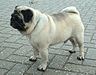

In [192]:
from PIL import Image

image = Image.open("pug.jpg")
image

In [193]:
x0 = np.array(image).astype(np.float32) / 255.0
x0.shape

(75, 96, 3)

In [194]:
class Diffusion:
    def __init__(self, diff_steps = 1000):
        self.diff_steps = diff_steps
        self.betas = np.linspace(1e-4, 0.02, diff_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)
        
    def forward(self, x_0, t):
        epsilon = np.random.randn(*x_0.shape)
        alpha_bar = self.alpha_bars[t]
        x_t = np.sqrt(alpha_bar) * x_0 + np.sqrt(1 - alpha_bar) * epsilon
        return x_t, epsilon

    def recover(self, x_t, t, epsilon):
        alpha_bar = self.alpha_bars[t]
        x_0 = (1 / np.sqrt(alpha_bar)) * (x_t - np.sqrt(1 - alpha_bar) * epsilon)
        return x_0.reshape(28, 28)


In [195]:
model = Diffusion()

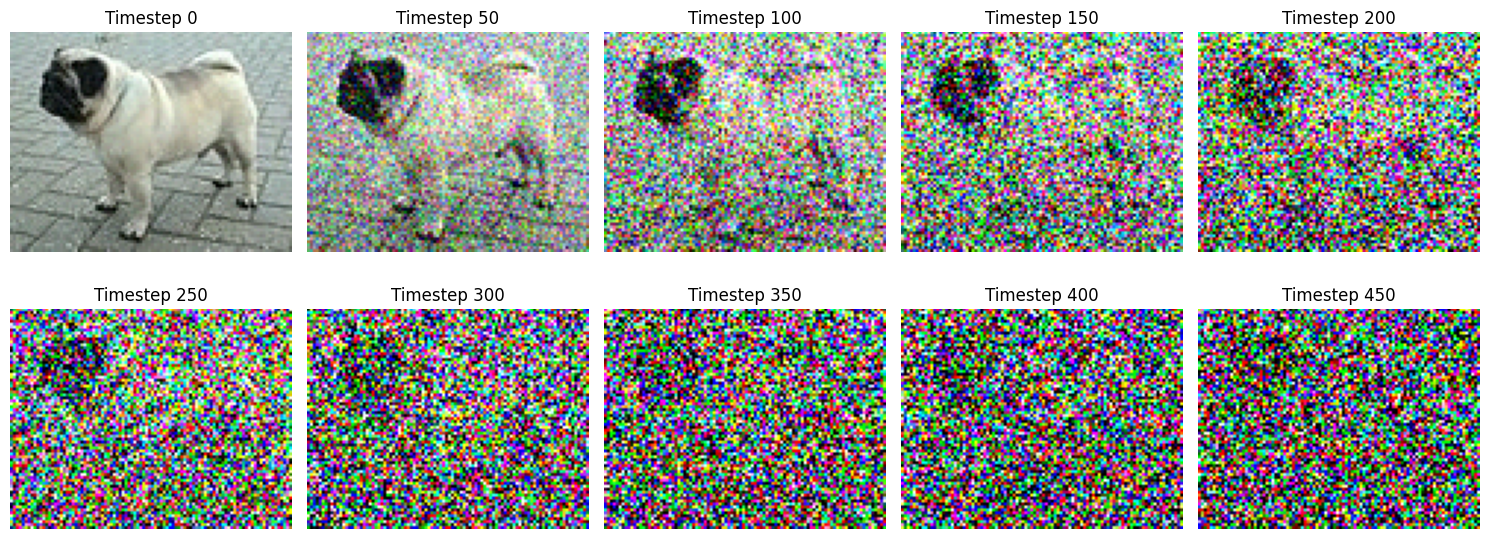

In [196]:
timesteps = [i for i in range(0, 500, 50)]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, t in enumerate(timesteps):
    row = i // 5
    col = i % 5
    xt, epsilon = model.forward(x0, t)
    axes[row, col].imshow(np.clip(xt, 0, 1))
    axes[row, col].set_title(f"Timestep {t}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [197]:
# For sake of simplicity, we'll use mlp rather than UNet for reversing the diffusion process

# Taken from CNN implementation
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.random.randn(output_size) * 0.1

    def forward(self, x):
        self.input = x
        return self.weights @ x + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.outer(grad_output, self.input)
        self.grad_biases = grad_output

        return self.weights.T @ grad_output

    def update(self, lr):
        self.weights -= lr * self.grad_weights
        self.biases -= lr * self.grad_biases

class Relu:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)

    def update(self, lr):
        for layer in self.layers:
            if hasattr(layer, "update"):
                layer.update(lr)

class MSE:
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return np.mean((pred - target) ** 2)

    def backward(self):
        return 2 * (self.pred - self.target) / self.pred.size

In [206]:
model = Model([
    Dense(784 + 1, 256), # 784 from image 1 from our scalar timestep
    Relu(),
    Dense(256, 256),
    Relu(),
    Dense(256, 784)
    
])

diffusion_model = Diffusion()

In [213]:
def train(model, diffusion_model, trainX, epoch = 10):
    loss_fn = MSE()
    lr = 1e-3

    for i in range(epoch):
        for x_0 in trainX:
            T = diffusion_model.diff_steps
            t = np.random.randint(0, T - 1)
            x_t, epsilon = diffusion_model.forward(x_0, t)
            x_in = np.concatenate([x_t.flatten(), [t / T]])
    
            epsilon_pred = model.forward(x_in)
            loss = loss_fn.forward(epsilon_pred, epsilon.flatten())
    
            model.backward(loss_fn.backward())
            model.update(lr)
    
        print(f"Epoch {i}: loss is {loss}")

In [208]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.int32)

X = X / 255.0
X = X.reshape(-1, 28, 28)

X_train, X_test = X[:-10], X[-10:]
y_train, y_test = y[:-10], y[-10:]

In [214]:
train(model, diffusion_model, X_train)

Epoch 0: loss is 0.9787724028506004
Epoch 1: loss is 1.0525271442880484
Epoch 2: loss is 1.0530688870516827
Epoch 3: loss is 0.9953361338954195
Epoch 4: loss is 1.100700624575314


KeyboardInterrupt: 

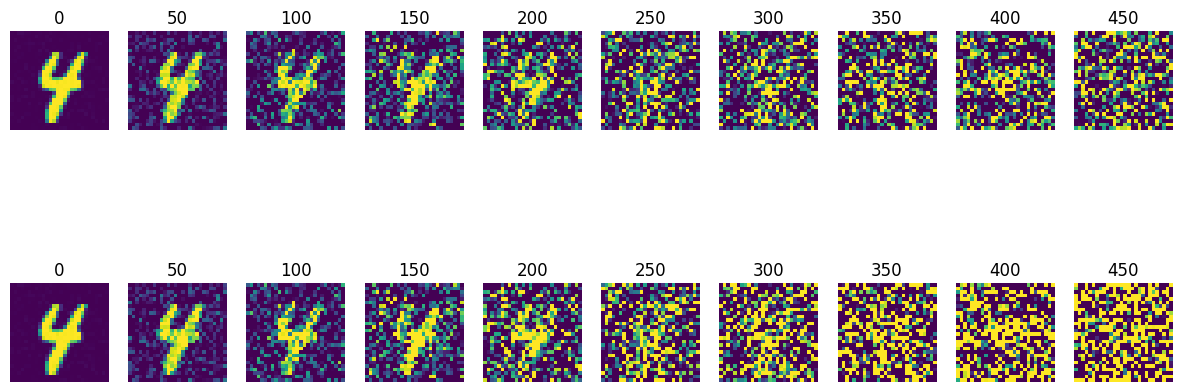

In [218]:
timesteps = [i for i in range(0, 500, 50)]

corrupted = []
predicted = []

for x_0 in X_test:
    sample_corrupted = []
    sample_predicted = []
    for t in timesteps:
        c = diffusion_model.forward(x_0, t)[0]
        x_t = c.flatten() 
        epsilon_pred = model.forward(np.concatenate([x_t, [t / T]]))
        p = diffusion_model.recover(x_t, t, epsilon_pred)
        
        sample_corrupted.append((t, c))
        sample_predicted.append((t, p))
    corrupted.append(sample_corrupted)
    predicted.append(sample_predicted)
    
    
    
fig, axes = plt.subplots(2, len(timesteps), figsize=(15, 6))

for idx, ((t, x_t), (_t, p)) in enumerate(zip(corrupted[7], predicted[7])):
    axes[0, idx].imshow(np.clip(x_t, 0, 1))
    axes[0, idx].set_title(t)
    axes[1, idx].imshow(np.clip(p, 0, 1))
    axes[1, idx].set_title(t)
    axes[0, idx].axis("off")
    axes[1, idx].axis("off")
